Project by: Ittoop Shinu Shibu(A13719148), Bernard Wong(A15268417)

## Mini-Project # 3

Is it more or less likely to be injured in a bike-related accident if you are on a bike path or not? How would the results differ for injuries of different severity, by zip codes, and by the type of other party in the accident? In which parts of the city is it more likely to get into an alcohol-related accident? How can you explain that using additional statistics by zip codes, for example, by the number of alcohol-serving bars in the zip code? 

Let's answer these questions using Arcgis API for Python. This is your third mini-project.

Recall the very first demo in the first lecture: we searched available content for "bike san diego", and found several layers or services, including collisions and bike routes. The collisions file showed bike and pedestrian TIMS-geocoded collisions in SD County (TIMS == Transpotation Injury Mapping System.) You can view the system description, including definitions of fields, at https://tims.berkeley.edu/help/SWITRS.php (SWITRS == Statewide Integrated Traffic Records System from CA Highway Patrol). There is a field indicating accidents that involved bicyclists. 

To answer the questions at the top of the cell, we'll need to integrate bike paths and accidents. But notice that the data we found through ArcGIS search during the first lecture, were for different times. So our first task is to grab more recent data and add it to the notebook you create. 

Your tasks, therefore, include:
1. Create an account at https://tims.berkeley.edu/, and sign in.
1. At SWITRS Query and Map, make a request for data from 1/1/2014 to 12/31/2018, for one or more cities in San Diego county (or just San Diego city.)  Specify that you are interested in bicycle collisions, and run the query.
1. Make sure that you get back 1000 or more records (e.g. if you select just San Diego city, you'd get 2289 total bicycle collisions). 
1. Download the collision data as a csv file, and explore it. Also, download party and victims data, because some attributes you'd need are in these files.
1. Explore the data you downloaded, and understand the fields you need to work with. See SWITRS FAQ page at https://tims.berkeley.edu/help/Query_and_Map.php#FAQs and the codebook at https://tims.berkeley.edu/help/SWITRS.php#Codebook. SWITRS is relatively well documented.
1. Find the field that is common for the 3 tables (this is what you can use to join them). Note, also, that there are similarly-named fields in the three tables, but they apply to different types. For example, "party sobriety" is a field in the "party" table (here, you can tell who in the collision was under the influence), while there is also an "alchohol involved" field in the collision table.
1. Read the collisions table into a Jupyter notebook, and create point map for it. Join other tables (possibly using group by) to this table. Also, save the table as a feature service into ArcGIS Online. 
1. Identify those collisions that happened along a bike path, and those that happened elsewhere. This may be tricky. Think about geometric meaning of "being on a bike path". Also, think which ArcGIS techniques you could use to connect data from the Collisions and the Bike Routes layers.
1. Summarize collisions by zip codes, and also add additional data to the zip codes table, using geoenrichment (you may want to look at variables in categories such as businesses, GroceryAlcoholicBeverages, LeisureActivitiesLifestyle, food). You may also use the businesses data you worked with in MP2. To find a zip codes feature layer or shapefile, search extarnal content on ArcGIS Online.
1. Do analysis of the collisions and zip codes layers, answering the questions at the top of this cell. Use a data analysis technique (eg regression) you learned in an earlier course. For example, you may use sklearn to build a model explaining severity of injuries as dependent on impairment, type of collision, and location. 

What you need to produce:
1. Map (or maps) of bicycle-related accidents and bike paths, where accidents are shown with different colors or symbols depending on whether a)alcohol was involved, b) the bicyclist was at fault because of impairment, and c) type of the other party in the accident.
2. Map by zip codes showing the alcohol-related bicycle accidents and one other variable by zip codes that may explain it (based on your findings)
3. Documented Jupyter Notebook with step-by-step analysis 
4. A brief description of findings (300 words or more)
5. URLs of resources you created on ArcGIS Online 

4. For extra credit: a) find additional interesting information by joining the victims table, b) how would you present these findings to a local planning commission that considers where to create bike paths avoiding areas that are prone to serious collisions? 


### Useful web sites about the problem:

* https://www.afr.com/lifestyle/cars-bikes-and-boats/cycling/where-most-car-and-bicycle-collisions-take-place-and-how-to-avoid-them-20161018-gs4ikm
* https://www.quora.com/How-do-most-vehicle-bicycle-collisions-occur
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3503407/
* https://cityroom.blogs.nytimes.com/2009/04/09/study-links-alcohol-and-bike-deaths/


In [1]:
# 1. Load the data (using concent manager, and also adding downloaded datasets), retain only fields we need
# You code goes here


In [2]:
import arcgis
from arcgis.gis import GIS
from arcgis import geometry
from arcgis.features import GeoAccessor, GeoSeriesAccessor
import pandas as pd


In [3]:
gis = GIS(username='ishibu_UCSDOnline')

Enter password: ········


In [4]:
from arcgis.geoenrichment import *

In [5]:
from arcgis.features.find_locations import find_existing_locations

In [6]:
import numpy as np

In [7]:
from arcgis.features import use_proximity

In [8]:
from arcgis.features.use_proximity import create_buffers

In [9]:
collisions = pd.read_csv('Bicycle_Collision/Collisions.csv')
parties = pd.read_csv('Bicycle_Collision/Parties.csv')
victims = pd.read_csv('Bicycle_Collision/Victims.csv')

In [10]:
collisions['CASE_ID'].nunique()

2289

In [11]:
parties['CASE_ID'].nunique()

2289

In [12]:
victims['CASE_ID'].nunique()

2289

# SETUP 

With all the csv's read in, we went ahead and narrowed down the columns that we deemed most important. Our main focus is on the collisions and parties csv, so we went through the columns and narrowed it down to the bare necessities. Here are the columns we decided were most important:

In [13]:
collisions = collisions[['CASE_ID','POPULATION','COLLISION_SEVERITY','NUMBER_KILLED','NUMBER_INJURED','PARTY_COUNT','PRIMARY_COLL_FACTOR','PEDESTRIAN_ACCIDENT','BICYCLE_ACCIDENT','MOTORCYCLE_ACCIDENT','TRUCK_ACCIDENT','ALCOHOL_INVOLVED','COUNT_PED_KILLED','COUNT_PED_INJURED','COUNT_BICYCLIST_KILLED','COUNT_BICYCLIST_INJURED','COUNT_MC_KILLED','COUNT_MC_INJURED','LATITUDE','LONGITUDE','COUNTY','CITY','POINT_X','POINT_Y']]

In [14]:
parties = parties[['CASE_ID', 'PARTY_NUMBER','PARTY_TYPE','PARTY_SEX','PARTY_AGE','PARTY_SOBRIETY','PARTY_DRUG_PHYSICAL']]

In [15]:
# 2. Joining party (and  victims, if going for extra credit) to collisions. 
# You code goes here


# Merging the tables

In order to perform some geographic analysis, we need to be join these tables. The common column is 'CASE_ID', but there are issues with parties; parties has repeats of 'CASE_ID's due to a report being made for each member involved in each case. As a result, we decided to simplify cases and group them into each unique 'CASE_ID' and the unique count within 'PARTY_TYPE' and 'PARTY_SOBRIETY'.

In [16]:
parties = parties.replace({'-':np.NaN})
party_type = pd.DataFrame(parties.groupby('CASE_ID')['PARTY_TYPE'].value_counts())
party_type.columns = ['number']
party_type = party_type.reset_index()
party_type = pd.pivot_table(party_type,columns = 'PARTY_TYPE',index = 'CASE_ID', values = 'number')
party_type = party_type.replace({np.NaN:0})
party_type.columns = ['1','2', '3','4','5']
party_type = party_type.reset_index()

In [17]:
parties = parties.replace({'-':np.NaN})
alcohol_type = pd.DataFrame(parties.groupby('CASE_ID')['PARTY_SOBRIETY'].value_counts())
alcohol_type.columns = ['number']
alcohol_type = alcohol_type.reset_index()
alcohol_type = pd.pivot_table(alcohol_type,columns = 'PARTY_SOBRIETY',index = 'CASE_ID', values = 'number')
alcohol_type = alcohol_type.replace({np.NaN:0})
alcohol_type = alcohol_type.drop(columns=['G','H'])
alcohol_type['NUM_ALCOHOL'] = alcohol_type.apply(lambda x: x['B']+x['C']+x['D'], axis=1)
alcohol_type = alcohol_type.drop(columns=['B','C','D'])
alcohol_type.columns = ['NUM_NON_ALCOHOL','NUM_ALCOHOL']
alcohol_type = alcohol_type.reset_index()

In [18]:
party_merged = pd.merge(party_type, alcohol_type)

After resolving the multiple cases in 'CASE_ID' for parties, we are able to merge collisions and parties together to get the proper DataFrame.

In [19]:
collision_party_merged = pd.merge(collisions, party_merged)
collision_party_merged.head()

,CASE_ID,POPULATION,COLLISION_SEVERITY,NUMBER_KILLED,NUMBER_INJURED,PARTY_COUNT,PRIMARY_COLL_FACTOR,PEDESTRIAN_ACCIDENT,BICYCLE_ACCIDENT,MOTORCYCLE_ACCIDENT,...,CITY,POINT_X,POINT_Y,1,2,3,4,5,NUM_NON_ALCOHOL,NUM_ALCOHOL
0,90581634,7,3,0,1,1,C,NaN,Y,NaN,...,SAN DIEGO,-117.10352,33.022082,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,90410428,7,4,0,1,2,A,NaN,Y,NaN,...,SAN DIEGO,NaN,NaN,1.0,0.0,0.0,1.0,0.0,2.0,0.0
2,90027314,7,3,0,1,1,B,NaN,Y,NaN,...,SAN DIEGO,NaN,NaN,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,90196205,7,4,0,1,2,A,NaN,Y,NaN,...,SAN DIEGO,-117.10919,33.005710,1.0,0.0,0.0,1.0,0.0,2.0,0.0
4,90124838,7,2,0,1,2,A,NaN,Y,NaN,...,SAN DIEGO,-117.20530,32.760460,1.0,0.0,0.0,1.0,0.0,1.0,1.0


In [20]:
!pip install --user pyshp==1.2.12

In [21]:
# 3. Clean spatial data as needed and create a point layer of collisions
# You code goes here


# Creating a pointmap of collision

Now that we were able to merge the dataframes successfully, we're aiming to start visualizing our data to start to understand what our data means. We're first going to clean up our spatial data (to ensure no missing data) and then create a point map of all the collisions that occured in SD for the year.

In [22]:
# need to convert to spatial due to the large amount of data 
import numpy as np
sdf = pd.DataFrame.spatial.from_xy(collision_party_merged,x_column = 'POINT_X', y_column='POINT_Y')
sdf1 = sdf.replace(np.nan, '', regex=True)
sdf1.head()

# might be doing this wrong? Wasn’t sure how to save to external file 
sdf_fl = sdf1.spatial.to_featurelayer(title='test', tags='sample data')

# sdf2 = pd.DataFrame.spatial.from_featureclass('*/TEST.shp')
# shp_properties = {'title':'test', 'tags':'sample data'}
# collisions_shapefile = gis.content.add(item_properties = shp_properties, data=sdf2)

In [24]:
sdf_fl

<Item title:"test" type:Feature Layer Collection owner:ishibu_UCSDOnline>

In [28]:
sdf1.dtypes

CASE_ID                       int64
POPULATION                    int64
COLLISION_SEVERITY            int64
NUMBER_KILLED                 int64
NUMBER_INJURED                int64
PARTY_COUNT                   int64
PRIMARY_COLL_FACTOR          object
PEDESTRIAN_ACCIDENT          object
BICYCLE_ACCIDENT             object
MOTORCYCLE_ACCIDENT          object
TRUCK_ACCIDENT               object
ALCOHOL_INVOLVED             object
COUNT_PED_KILLED              int64
COUNT_PED_INJURED             int64
COUNT_BICYCLIST_KILLED        int64
COUNT_BICYCLIST_INJURED       int64
COUNT_MC_KILLED               int64
COUNT_MC_INJURED              int64
LATITUDE                     object
LONGITUDE                    object
COUNTY                       object
CITY                         object
POINT_X                      object
POINT_Y                      object
1                           float64
2                           float64
3                           float64
4                           

In [23]:
# Now we can show this layer on a map

m = gis.map('San Diego, California')
m.add_layer(sdf_fl)
m

MapView(layout=Layout(height='400px', width='100%'))

In [24]:
# 4. Define what you mean to be on a bike route, 
# and figure out, for each collision, whether it happened on a bike route or not. 
# Summarize collisions of different types by zip codes.
# You code goes here


# More in depth on bike path collisions

We've successfully created and imported our feature layer of collisions! This is what the map looks like, along with San Diego Bike Routes marked in purple
As you can tell by the above map, there are a lot of collisions. However, we're particularly interested in the collisions that occured on bike paths. Because not all collisions will be marked directly on bike paths, we decided to pad each collision point with buffer zones of 15 feet. This way we'll be able to find collisions that occurred relatively close to or on bike paths.

In [25]:
san_diego_bike_routes = gis.content.search('title: SanDiegoBikeRoutes','Feature layer',outside_org=True)[0].layers[0]
buffer_points = create_buffers(sdf_fl, distances=[15], units='Feet')
buffer_layer = buffer_points.query().df.to_featurelayer(title='buffers',tags='sample data')
buffer_points_sdf = pd.DataFrame.spatial.from_layer(buffer_layer.layers[0])
bike_sdf =  pd.DataFrame.spatial.from_layer(san_diego_bike_routes)
sdf_joined = buffer_points_sdf.spatial.join(bike_sdf)
temp = pd.DataFrame.spatial.from_xy(sdf_joined,x_column = 'POINT_X', y_column='POINT_Y')
temp = temp.replace(np.nan, '', regex=True)
bike_buffer_fl = temp.spatial.to_featurelayer(title='Bike&Buffer', tags='sample data')
def in_bike_path(x):
    if x['CASE_ID'] in list(temp['CASE_ID']):
        return True
    return False

#adds a column to collision_party_merged if that states if the point is on a bike path or not
collision_party_merged['ON_BIKE_PATH']=collision_party_merged.apply(lambda x: in_bike_path(x), axis=1)

In [26]:
m3 = gis.map('San Diego, California')
m3.add_layer(bike_buffer_fl)
m3.add_layer(san_diego_bike_routes)
m3

MapView(layout=Layout(height='400px', width='100%'))

In [27]:
zip_code = gis.content.search('title: Zipcodes, owner: jluostarinen','Feature layer',outside_org=True)[0].layers[0]
zip_code_sdf = pd.DataFrame.spatial.from_layer(zip_code)
point_sdf = pd.DataFrame.spatial.from_layer(sdf_fl.layers[0])
zip_joined = zip_code_sdf.spatial.join(point_sdf)
zip_codes_processed = pd.DataFrame(zip_joined.groupby('CASE_ID')['ZIP'].value_counts())
zip_codes_processed.columns= ['ZIP_CODES']
zip_codes_processed = zip_codes_processed.reset_index().drop(columns=['ZIP_CODES'])
collision_party_merged_zip_codes = pd.merge(zip_codes_processed, collision_party_merged)

In [28]:
zip_string = list(collision_party_merged_zip_codes.apply(lambda x: str(x['ZIP']), axis=1))
en = enrich(study_areas=zip_string, data_collections=['GroceryAlcoholicBeverages'])
lst_columns = []
for i in list(en.columns)[2:324]:
    if 'a_' not in i:
        lst_columns.append(i)
en_alcohol = en.drop(columns=lst_columns, axis=1)

In [69]:
list(en_alcohol.columns)

['HasData',
 'ID',
 'MP04001a_B',
 'MP04001a_I',
 'MP04002a_B',
 'MP04002a_I',
 'MP04003a_B',
 'MP04003a_I',
 'MP04004a_B',
 'MP04004a_I',
 'MP04005a_B',
 'MP04005a_I',
 'MP04006a_B',
 'MP04006a_I',
 'MP04008a_B',
 'MP04008a_I',
 'MP04009a_B',
 'MP04009a_I',
 'MP04010a_B',
 'MP04010a_I',
 'MP04011a_B',
 'MP04011a_I',
 'MP04012a_B',
 'MP04012a_I',
 'MP04013a_B',
 'MP04013a_I',
 'MP04014a_B',
 'MP04014a_I',
 'MP04015a_B',
 'MP04015a_I',
 'MP04016a_B',
 'MP04016a_I',
 'MP04017a_B',
 'MP04017a_I',
 'MP04018a_B',
 'MP04018a_I',
 'MP04019a_B',
 'MP04019a_I',
 'MP04020a_B',
 'MP04020a_I',
 'MP04021a_B',
 'MP04021a_I',
 'MP04022a_B',
 'MP04022a_I',
 'MP04023a_B',
 'MP04023a_I',
 'MP04024a_B',
 'MP04024a_I',
 'MP04025a_B',
 'MP04025a_I',
 'MP04026a_B',
 'MP04026a_I',
 'MP04027a_B',
 'MP04027a_I',
 'MP04028a_B',
 'MP04028a_I',
 'MP04029a_B',
 'MP04029a_I',
 'MP04030a_B',
 'MP04030a_I',
 'MP04031a_B',
 'MP04031a_I',
 'MP04032a_B',
 'MP04032a_I',
 'MP04033a_B',
 'MP04033a_I',
 'MP04034a_B',
 'MP04

In [209]:
# 5. Generate maps
# You code goes here


In [201]:
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [ ]:
# 6. Analyze the data and write responses to the above questions
# You code goes here


In [461]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

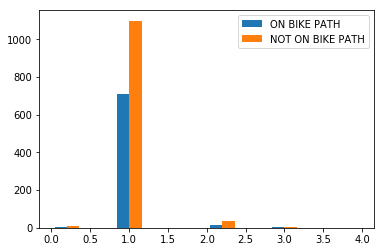

In [462]:

injury_bike_path_stats = collision_party_merged_zip_codes[['NUMBER_INJURED','ON_BIKE_PATH']]
x = injury_bike_path_stats[injury_bike_path_stats['ON_BIKE_PATH']==True]['NUMBER_INJURED']
y = injury_bike_path_stats[injury_bike_path_stats['ON_BIKE_PATH']==False]['NUMBER_INJURED']

plt.hist([x, y],label=['ON BIKE PATH', 'NOT ON BIKE PATH'])
plt.legend(loc='upper right')

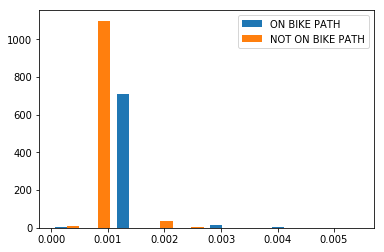

In [463]:
injury_bike_path_stats = collision_party_merged_zip_codes[['NUMBER_INJURED','ON_BIKE_PATH']]
x = injury_bike_path_stats[injury_bike_path_stats['ON_BIKE_PATH']==True]['NUMBER_INJURED']/len(
    injury_bike_path_stats[injury_bike_path_stats['ON_BIKE_PATH']==True])
y = injury_bike_path_stats[injury_bike_path_stats['ON_BIKE_PATH']==False]['NUMBER_INJURED']/len(
    injury_bike_path_stats[injury_bike_path_stats['ON_BIKE_PATH']==False])

plt.hist([x, y],label=['ON BIKE PATH', 'NOT ON BIKE PATH'])
plt.legend(loc='upper right')

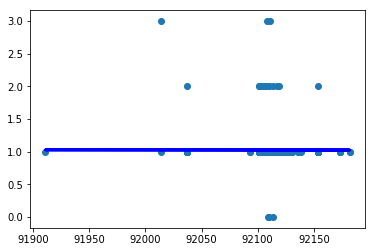

In [464]:
lm = LinearRegression()
X = collision_party_merged_zip_codes['ZIP']
X = np.array(list(X)).reshape(-1, 1)
y = collision_party_merged_zip_codes['NUMBER_INJURED']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
lm.fit(X_train,y_train)
prediction =lm.predict(X_test)
plt.scatter(X_test, y_test)
plt.plot(X_test, prediction, color='blue', linewidth=3)

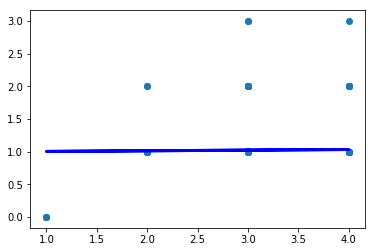

In [465]:
lm = LinearRegression()
X = collision_party_merged_zip_codes['COLLISION_SEVERITY']
X = np.array(list(X)).reshape(-1, 1)
y = collision_party_merged_zip_codes['NUMBER_INJURED']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
lm.fit(X_train,y_train)
prediction =lm.predict(X_test)
plt.scatter(X_test, y_test)
plt.plot(X_test, prediction, color='blue', linewidth=3)

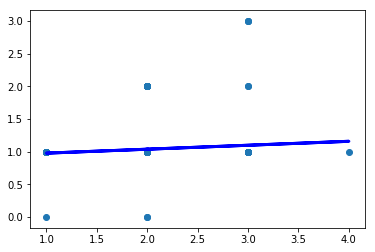

In [466]:
lm = LinearRegression()
X = collision_party_merged_zip_codes['PARTY_COUNT']
X = np.array(list(X)).reshape(-1, 1)
y = collision_party_merged_zip_codes['NUMBER_INJURED']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
lm.fit(X_train,y_train)
prediction =lm.predict(X_test)
plt.scatter(X_test, y_test)
plt.plot(X_test, prediction, color='blue', linewidth=3)

YOUR ANSWER HERE

YOUR ANSWER HERE

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# Please let us know how much time you spent on this project, in hours: 
# (we will only examine distributions and won't look at individual responses)
assignment_timespent = 
extracredit_timespent = 